# Imports

In [5]:
import json
import os
!gc-monitor

+---------------+---------------------------------------------------------------------------------+
|  gc-monitor   |         Partition: 109267-reconfig [active] has 16 reconfigurable IPUs          |
+-------------+--------------------+--------+--------------+----------+-------+----+------+-------+
|    IPU-M    |       Serial       |IPU-M SW|Server version|  ICU FW  | Type  | ID | IPU# |Routing|
+-------------+--------------------+--------+--------------+----------+-------+----+------+-------+
|  10.5.48.1  | 0020.0002.8221721  | 2.6.0  |    1.11.0    |  2.5.9   | M2000 | 0  |  3   |  DNC  |
|  10.5.48.1  | 0020.0002.8221721  | 2.6.0  |    1.11.0    |  2.5.9   | M2000 | 1  |  2   |  DNC  |
|  10.5.48.1  | 0020.0001.8221721  | 2.6.0  |    1.11.0    |  2.5.9   | M2000 | 2  |  1   |  DNC  |
|  10.5.48.1  | 0020.0001.8221721  | 2.6.0  |    1.11.0    |  2.5.9   | M2000 | 3  |  0   |  DNC  |
+-------------+--------------------+--------+--------------+----------+-------+----+------+-------+


# Define zero-out thresholds, molecules and utils

In [3]:

results_file = ".cache/results_cache.json"
iterations  = [2, 5, 8, 11, 14, 17, 20]
ao_thresholds = [10**(-i) for i in range(2, 11)]
mols = [
    'benzene', 'methane', 
    'c_4', 'c_8', 'c_16', 'c_32', 
    # 'TRP', 'LYN', 'TYR', 'PHE', 'LEU', 
    # 'ILE', 'HIE', 'MET', 'GLN', 'HID',
    # 'GLH', 'VAL', 'GLU', 'THR', 'PRO',
    # 'ASN', 'ASH', 'ASP', 'SER', 'CYS',
    # 'CYX', 'ALA', 'GLY'
]

# Completion tracking
def print_completion(results: dict):
    total_calls = len(ao_thresholds) * len(mols)
    completed_calls = len(results)
    completion_percentage = (completed_calls / total_calls) * 100
    print(f"Completion: {completed_calls}/{total_calls} ({completion_percentage:.2f}%)")

# Load results if cache exists

In [6]:
if not os.path.exists('.cache'):
    os.makedirs('.cache')

if os.path.exists(results_file):
    with open(results_file, 'r') as f:
        str_results = json.load(f)
    results = {}
    for key, value in str_results.items():
        mol, thresh = key.split(":")
        results[(mol, float(thresh))] = value
else:
    results = {}

print_completion(results)
print(results.keys())

Completion: 54/54 (100.00%)
dict_keys([('benzene', 1e-10), ('benzene', 1e-09), ('benzene', 1e-08), ('benzene', 1e-07), ('benzene', 1e-06), ('benzene', 1e-05), ('benzene', 0.0001), ('benzene', 0.001), ('methane', 1e-10), ('methane', 1e-09), ('methane', 1e-08), ('methane', 1e-07), ('methane', 1e-06), ('methane', 1e-05), ('methane', 0.0001), ('methane', 0.001), ('c_4', 1e-10), ('c_4', 1e-09), ('c_4', 1e-08), ('c_4', 1e-07), ('c_4', 1e-06), ('c_4', 1e-05), ('c_4', 0.0001), ('c_4', 0.001), ('c_8', 1e-10), ('c_8', 1e-09), ('c_8', 1e-08), ('c_8', 1e-07), ('c_8', 1e-06), ('c_8', 1e-05), ('c_8', 0.0001), ('c_8', 0.001), ('c_16', 1e-10), ('c_16', 1e-09), ('c_16', 1e-08), ('c_16', 1e-07), ('c_16', 1e-06), ('c_16', 1e-05), ('c_16', 0.0001), ('c_16', 0.001), ('c_32', 1e-10), ('c_32', 1e-09), ('c_32', 1e-08), ('c_32', 1e-07), ('c_32', 1e-06), ('c_32', 1e-05), ('c_32', 0.0001), ('c_32', 0.001), ('benzene', 0.01), ('methane', 0.01), ('c_4', 0.01), ('c_8', 0.01), ('c_16', 0.01), ('c_32', 0.01)])


# Compute results

In [7]:
def compute_results(results):
    import subprocess
    # Iterate over all combinations
    for mol in mols:
        for ao in ao_thresholds:
            pair = (mol, ao)
            # Skip if results already computed
            if pair in results: continue

            command = f"python ../pyscf_ipu/nanoDFT/nanoDFT.py --mol_str {mol} --ao_threshold {ao}"
            print(command)
            output = subprocess.check_output(command, shell=True).decode('utf-8')
            
            num_electrons  = None
            sparsity_level = None
            error_energy   = {}
            error_hlgap    = {}
            
            for line in output.split("\n"):
                if "Number of electrons"   in line: num_electrons  = line.split("  ")[-1].replace(' ', '')
                elif "axis=( ,  ) sparsity in grid_AO:"    in line: sparsity_level = line.split("=")[-1]
                elif "Error Energy"        in line: error_energy   = dict(zip(iterations, line.split()[-7:]))  
                elif "Error HLGAP"         in line: error_hlgap    = dict(zip(iterations, line.split()[-7:]))
                    
            results[pair] = {
                "num electrons":    num_electrons,
                "Sparsity Level":   sparsity_level,
                "Error Energy":     error_energy,
                "Error HLGAP":      error_hlgap
            }

            # Convert tuple keys to string before saving
            str_results = {f"{key[0]}:{key[1]}": value for key, value in results.items()}
            # Cache the results after each computation
            with open(results_file, 'w') as f:
                json.dump(str_results, f, indent=4)

            print_completion(results)

compute_results(results)

# Visualise results

/tmp/ipykernel_215206/419960530.py:34: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


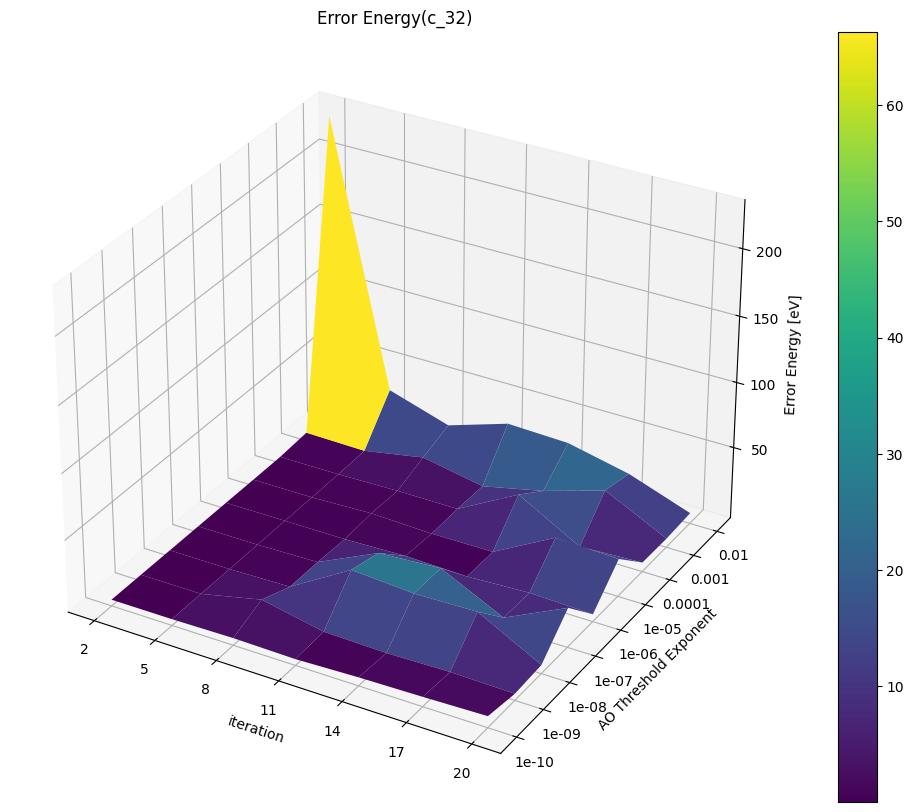

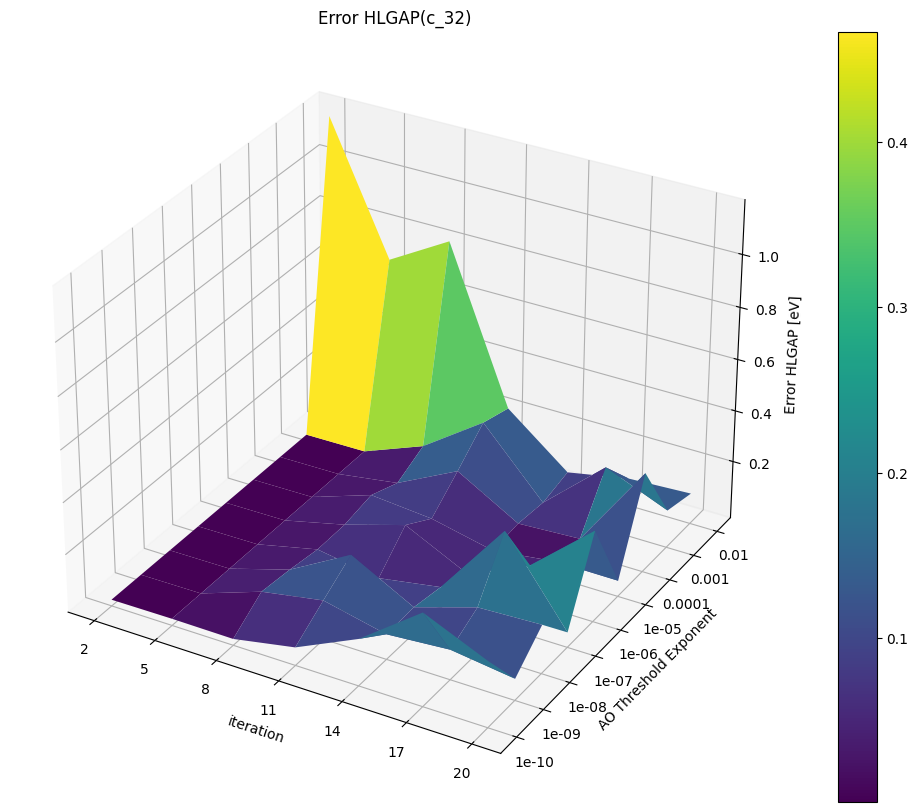

In [8]:
import matplotlib.pyplot as plt
import numpy as np

def plot_3d_surface(results, mol: str, metric="Error Energy"):
    assert mol in [key[0] for key in results.keys()]

    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    x = np.arange(len(iterations))
    y = np.arange(len(ao_thresholds))
    X, Y = np.meshgrid(x, y)
    
    Z = []
    
    for thresh in ao_thresholds[::-1]:
        row = []
        for iteration in iterations:
            row.append(abs(float(results[(mol, thresh)][metric][str(iteration)])))
        Z.append(row)

    Z = np.array(Z)
    surf = ax.plot_surface(X, Y, Z, cmap='viridis')
    
    ax.set_xticks(x)
    ax.set_xticklabels(iterations)
    ax.set_yticks(y)
    ax.set_yticklabels(ao_thresholds[::-1])
    ax.set_xlabel('iteration')
    ax.set_ylabel('AO Threshold Exponent')
    ax.set_zlabel(f'{metric} [eV]')
    ax.set_title(f'{metric}({mol})')
    fig.colorbar(surf)
    plt.tight_layout()
    plt.show()

plot_3d_surface(results, metric="Error Energy", mol='c_32')
plot_3d_surface(results, metric="Error HLGAP",  mol='c_32')

/tmp/ipykernel_215206/1090534932.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ao_thresholds)


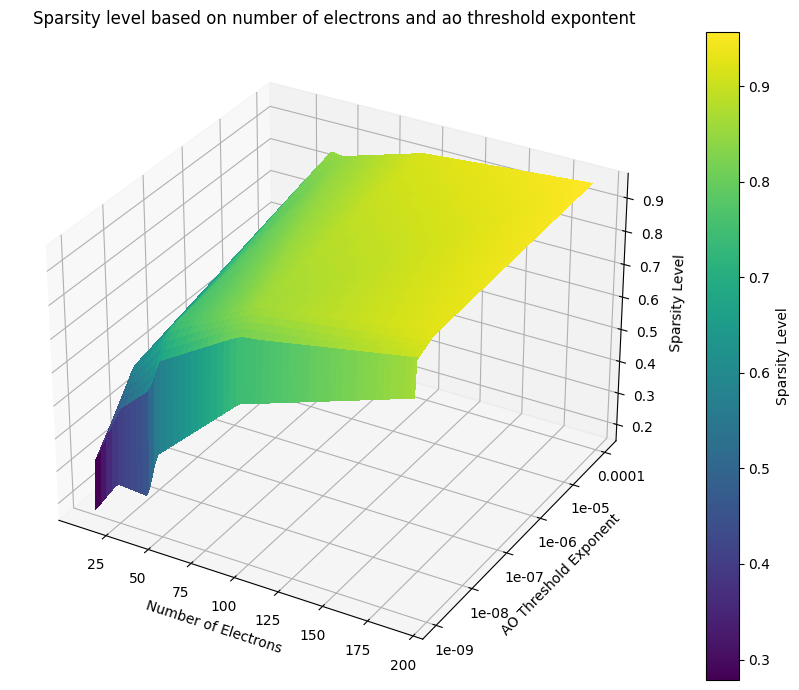

In [32]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

def plot_sparsity_3d_surface(results):
    assert len(results) > 1
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    num_electrons   = [float(results[pair]["num electrons"]) for pair in results]
    ao_thresholds   = [float(pair[1]) for pair in results]
    sparsity_levels = [float(results[pair]["Sparsity Level"]) for pair in results]

    # Create a grid over the data
    xi     = np.linspace(min(num_electrons), max(num_electrons), 100)
    yii    = np.linspace(min(ao_thresholds), max(ao_thresholds), 100)
    xi, yi = np.meshgrid(xi, yii)
    zi = griddata((num_electrons, ao_thresholds), sparsity_levels, (xi, yi), method='linear')

    # 3D Surface plot
    surf = ax.plot_surface(xi, yi, zi, cmap="viridis", edgecolor='k', linewidth=0, antialiased=False)

    # Adding labels and title
    ax.set_title("Sparsity level based on number of electrons and ao threshold expontent")
    ax.set_xlabel("Number of Electrons")
    ax.set_ylabel("AO Threshold Exponent")
    ax.set_yticklabels(ao_thresholds)

    ax.set_zlabel("Sparsity Level")
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    
    # Adding colorbar based on sparsity level
    cbar = fig.colorbar(surf, ax=ax, orientation='vertical', label="Sparsity Level")

    # Display the plot
    plt.tight_layout()
    plt.show()

# Call the function to plot
plot_sparsity_3d_surface(results)
